code by **PAUL ANTONY**

# Digital Marketing Strategy - **Testing H2**

Lecturer: **Leontine van Geffen-Wenink, Ph.D. Candidate** & **Debarati Bhaumik, Ph.D.**

**Importing necessary libraries and dataset from repository.**
Dataset was firstly combined and afterwards cleaned within the first Notebook **'Cleaning_EDA'**. Following Hypothesis **H2a** and **H2b** , which will be stated afterwards, will be checked in this Notebook. Therefor the Notebook will look into the Effect of Media Presence on Engagement of Facebook Social Media Posts.

In [286]:
# Importing the necessary libraries

import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

#loading our cleaned dataset
df = pd.read_csv('combined_themepark_dataset.csv')
df_original_len = len(df)
print('Original length of dataframe:', df_original_len)

Original length of dataframe: 14909


In [287]:
df.head()

,date,profile,message,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,nr_likes,link_posts,picture_posts,video_posts,profile_id,post_id,link,followers,engagement
0,12/31/23 9:40 PM,wild adventures theme park,🎟️🚨 Today's the FINAL day to use your 2023 Sea...,16,2,2,2,NaN,13,NaN,1.0,NaN,84679583132,84679583132_770120045161180,https://www.facebook.com/617429960430190/posts...,low,17.083333
1,12/31/23 8:01 PM,fun spot america,See you next year! 😉 Don’t miss...,38,1,2,1,NaN,33,NaN,NaN,NaN,"1,8402E+11",184020466977_767286052104076,https://www.facebook.com/653224623510220/posts...,medium,35.000060
2,12/31/23 7:30 PM,fun spot america,Don't miss our HUGE firework display ! 🥳\n\n#f...,23,2,3,2,NaN,21,NaN,NaN,1.0,"1,8402E+11",184020466977_767267948772553,https://www.facebook.com/653224623510220/posts...,medium,25.000090
3,12/31/23 7:00 PM,disneyland paris,Fijne jaarwisseling! 🥂🎉\nEn tot volgend jaar 😉,646,52,12,56,NaN,478,NaN,1.0,NaN,"6,52389E+14",652389081615295_775974521237956,https://www.facebook.com/724434559725286/posts...,high,582.000007
4,12/31/23 7:00 PM,silverwood theme park,It's the last day of our New Year's Sale! Save...,17,2,0,2,NaN,16,NaN,NaN,1.0,"7,62702E+14",762701550509617_678920137770716,https://www.facebook.com/562559642740100/posts...,medium,20.000000


* **Main Research Question of the Report:** What strategies can US theme parks employ to enhance audience engagement based on insights from performance analysis on Facebook posts? <br>

* **Sub-Research Question for Hypothesis 2:** What impact do different types of posts (picture, video) have on the engagement levels of US Theme Park Facebook profiles? 

# **Testing Hypothesis 2**

* **H2a:** Posts including pictures generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.  

* **H2b:** Posts including videos generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles. 

In [288]:
#check if there are rows without data
df.isnull().sum()

date                         0
profile                      0
message                      0
nr_reactions                 0
nr_comments                  0
nr_shares                    0
comments/post                0
post_interaction_rate    12133
nr_likes                     0
link_posts               14370
picture_posts             3712
video_posts              12573
profile_id                   0
post_id                      0
link                         0
followers                    0
engagement                   0
dtype: int64

In [289]:
#check data types
df.dtypes

date                      object
profile                   object
message                   object
nr_reactions               int64
nr_comments                int64
nr_shares                  int64
comments/post              int64
post_interaction_rate    float64
nr_likes                   int64
link_posts               float64
picture_posts            float64
video_posts              float64
profile_id                object
post_id                   object
link                      object
followers                 object
engagement               float64
dtype: object

In [290]:
#list of column names to drop
columns_to_drop = ['message', 'date', 'profile_id', 'link']
#remove specified columns
df = df.drop(columns=columns_to_drop)

When examining the data type, it was found that there are a lot of missing values in the columns 'picture_posts' and 'video_posts'. This has to do with the fact that *if it was a picture post*, for example, the value 1 was assigned, on the other hand a NaN value remained. 

As a next step, I will now generate a new feature that combines this information. **So if it is a picture post, the value 1 is assigned. If it is a video post, the value 2 and if the post does not contain an image or video, the value 3.**

In [291]:
#setting conditions for the columns
conditions = [
    ~df['picture_posts'].isna(),  # Not NaN for Picture Posts
    ~df['video_posts'].isna()     # Not NaN for Video-posts
]

#updated values to assign based on the conditions: 1 for picture_posts, 2 for video_posts
values = [1, 2]

#create the new column 'post_type' with an 'other' category for everything else except picture and video posts
df['post_type'] = np.select(conditions, values, default=3)

#display the first few rows of the dataframe to verify the new column
df[['picture_posts', 'video_posts', 'post_type']].head()


,picture_posts,video_posts,post_type
0,1.0,NaN,1
1,NaN,NaN,3
2,NaN,1.0,2
3,1.0,NaN,1
4,NaN,1.0,2


In [292]:
#counting the occurrences of 1, 2, and 3 in the 'post_type' column
post_type_counts = df['post_type'].value_counts()
#displaying the counts
print(post_type_counts)

post_type
1    11197
2     2336
3     1376
Name: count, dtype: int64


So we can see, that there are `11197` columns containing picture_posts, `2336` columns containing video_posts and `1376` without any of those.

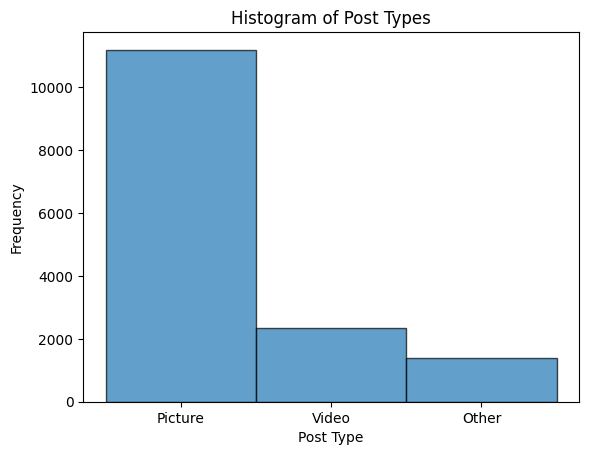

In [293]:
#plotting the histogram for the 'post_type' column
plt.hist(df['post_type'], bins=[0.5, 1.5, 2.5, 3.5], edgecolor='black', alpha=0.7)

#setting the x-ticks to correspond to the updated post types
plt.xticks(ticks=[1, 2, 3], labels=['Picture', 'Video', 'Other'])

#setting title and labels
plt.title('Histogram of Post Types')
plt.xlabel('Post Type')
plt.ylabel('Frequency')

#displaying the plot
plt.show()

In [294]:
#dropping the specified columns from the DataFrame
df = df.drop(columns=['link_posts', 'picture_posts', 'video_posts'])

In [295]:
#display df in a formatted table
print(tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════════════════╤════════════════╤═══════════════╤═════════════╤═════════════════╤═════════════════════════╤════════════╤═════════════════════════════════╤═════════════╤══════════════╤═════════════╕
│    │ profile                    │   nr_reactions │   nr_comments │   nr_shares │   comments/post │   post_interaction_rate │   nr_likes │                         post_id │ followers   │   engagement │   post_type │
╞════╪════════════════════════════╪════════════════╪═══════════════╪═════════════╪═════════════════╪═════════════════════════╪════════════╪═════════════════════════════════╪═════════════╪══════════════╪═════════════╡
│  0 │ wild adventures theme park │             16 │             2 │           2 │               2 │                     nan │         13 │     84679583132_770120045161180 │ low         │      17.0833 │           1 │
├────┼────────────────────────────┼────────────────┼───────────────┼─────────────┼─────────────────┼─────────────────────────┼──────

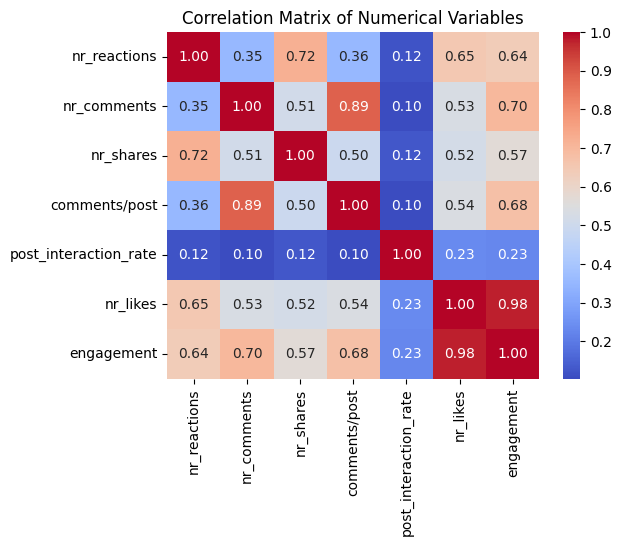

In [296]:
#preperation for correlation analysis on numerical columns, include all the float and int
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_cols].corr()
numerical_cols

#plotting the correlation matrix
plt.figure(figsize=(6, 4.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

### **Check Assumptions for the Two-Sample T-Test and ANOVA**

* **Independence:** Observations across all groups are independent.
* **Normality:**
<br> *T-Test:* Both groups' data should be roughly normal; less critical with larger samples.
<br> *ANOVA:* Residuals must be approximately normal.
* **Homogeneity of Variances:** Variances within each group should be similar. For violations, use Welch’s t-test (for two samples) or Welch ANOVA/Brown-Forsythe (for multiple groups).
* **Scale:** The dependent variable must be continuous (interval or ratio scale).
* **Random Sampling:** Data should come from a random sample of the population.

The **Shapiro-Wilk** test will be performed to *check the normality* of the `'engagement'` data, ensuring it meets the essential assumption for parametric statistical analyses, such as the Two-Sample T-Test and ANOVA. By assessing whether the data are normally distributed, this test helps validate the application of these methods. A p-value greater than 0.05 suggests the data is normally distributed, fulfilling the assumption, **while a lower p-value indicates a deviation from normality, possibly necessitating alternative approaches or data transformation.**

In [297]:
#apply the Shapiro-Wilk test on the engagement column
stat, p = shapiro(df['engagement'].dropna())

#print the test statistic and the p-value
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)

#interpret the results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Shapiro-Wilk Test Statistic: 0.6012907028198242
p-value: 0.0
Sample does not look Gaussian (reject H0)


c:\Users\paula\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The Shapiro-Wilk test shows a p-value of 0.0, indicating a statistically significant departure from normality for the `engagement` column. Consequently, the data **does not follow a normal distribution**, supporting the use of non-parametric statistical tests, such as the **Mann-Whitney U test**, for analyzing differences in engagement scores across different post types.

In [298]:
df.dtypes

profile                   object
nr_reactions               int64
nr_comments                int64
nr_shares                  int64
comments/post              int64
post_interaction_rate    float64
nr_likes                   int64
post_id                   object
followers                 object
engagement               float64
post_type                  int32
dtype: object

## **Hypothesis Testing with Mann Whitney U**

Looking at the assumptions check, the decision was made to utilize the **Mann-Whitney U test** for the subsequent steps of our research. This choice was necessitated due to the **failure of our dataset to meet the assumptions requisite** for **both the Analysis of Variance (ANOVA) and the two-sample t-test.** Specifically, the preliminary tests indicated that the data isnt following a normal distribution, which is a critical criterion for the before mentioned statistical methods. The Mann-Whitney U test, being a non-parametric alternative, does not require the data to follow a normal distribution, making it an appropriate method for analyzing the differences between our two independent samples under these conditions.

### Testing: **Content with Media** vs. **Content without Media**

In [299]:
#separate your data into two groups: one for posts with pictures and one for posts without
group_with_media = df[(df['post_type'] == 1) | (df['post_type'] == 2)]['engagement']
group_without_media = df[df['post_type'] == 3]['engagement']

#perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(group_with_media, group_without_media, alternative='greater')

#print the test statistic and p-value
print('Mann-Whitney U Test Statistic:', u_statistic)
print('p-value:', p_value)

#interpret the results
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.")
else:
    print("We fail to reject the null hypothesis. There is not a statistically significant difference in engagement scores between posts with media and without.")


Mann-Whitney U Test Statistic: 10199305.0
p-value: 2.5805255944739556e-09
We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.


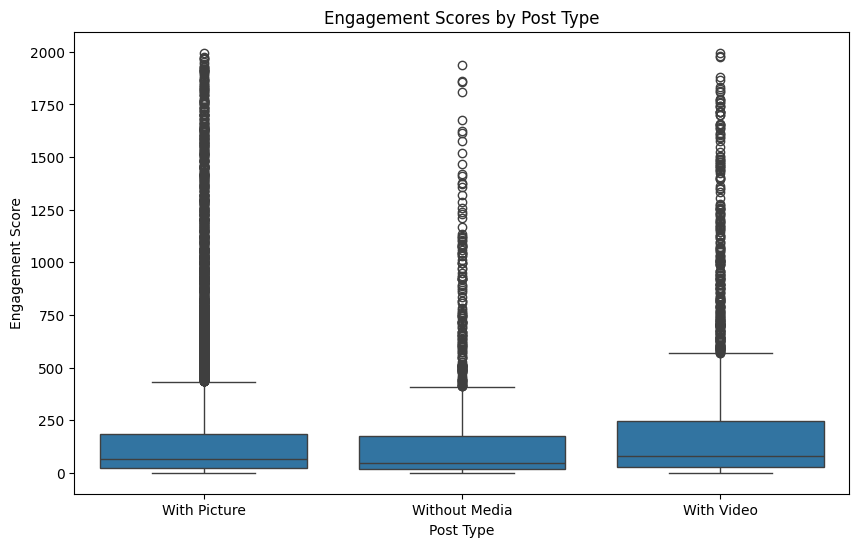

In [300]:
#map the post types to more descriptive labels
df['Post Type Label'] = df['post_type'].map({1: 'With Picture', 2: 'With Video', 3: 'Without Media'})

#filter out the post types
plot_data = df[df['post_type'].isin([1, 2, 3])]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Post Type Label', y='engagement', data=plot_data)
plt.title('Engagement Scores by Post Type')
plt.xlabel('Post Type')
plt.ylabel('Engagement Score')
plt.show()


**Interpretation:** The box plot suggests that **posts with videos receive the highest median engagement**, followed by posts with pictures, and then posts without media. Both media categories have a wide range of scores, but **video posts show a stronger potential for higher engagement.**

### Testing: **Content with Picture** vs. **Content without Media**

In [301]:
#separate your data into two groups: one for posts with videos and one for posts without
group_with_media = df[(df['post_type'] == 1) | (df['post_type'] == 1)]['engagement']
group_without_media = df[df['post_type'] == 3]['engagement']

#perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(group_with_media, group_without_media, alternative='greater')

#print the test statistic and p-value
print('Mann-Whitney U Test Statistic:', u_statistic)
print('p-value:', p_value)

#interpret the results
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.")
else:
    print("We fail to reject the null hypothesis. There is not a statistically significant difference in engagement scores between posts with media and without.")


Mann-Whitney U Test Statistic: 8316353.5
p-value: 7.067090941925932e-07
We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.


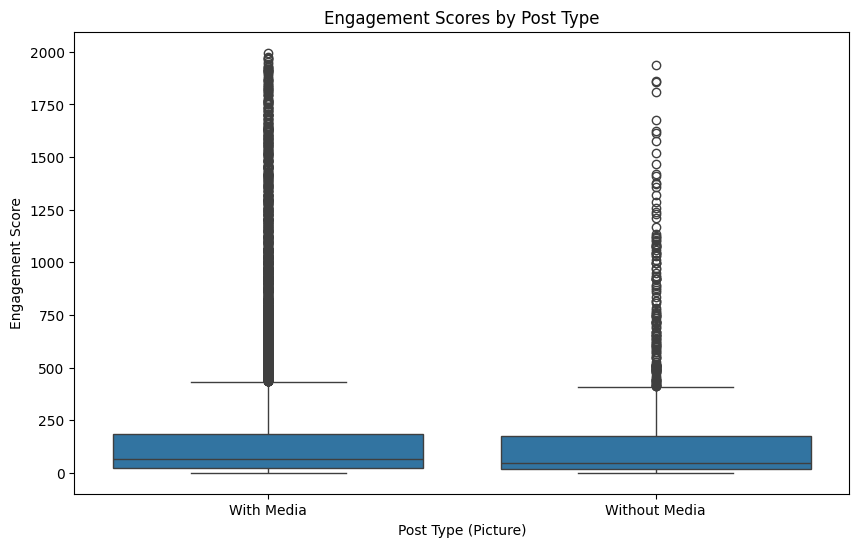

In [302]:
#where 1 indicates posts with media and 3 indicates posts without media

#create a new column for ease of plotting
df['Group'] = df['post_type'].apply(lambda x: 'With Media' if x == 1 else 'Without Media' if x == 3 else 'Other')

#create a boxplot to visualize the engagement scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='engagement', data=df[df['Group'].isin(['With Media', 'Without Media'])])
plt.title('Engagement Scores by Post Type')
plt.xlabel('Post Type (Picture)')
plt.ylabel('Engagement Score')
plt.show()


The box plot displays the engagement scores for two different types of social media posts: those **with media (picture)** and those **without media**. The *'With Media (picture)' category shows a wider range of scores, with a substantially higher median compared to the 'Without Media' category, which has a lower median engagement score and a much narrower interquartile range (IQR).* The presence of outliers, especially in the 'With Media' category, suggests that some posts with media achieve extraordinarily high engagement. The broader spread in the 'With Media' category indicates variability in how well different posts with media perform in terms of engagement.

In order to see the results of the Box-Plots better, **Outliers were removed.**

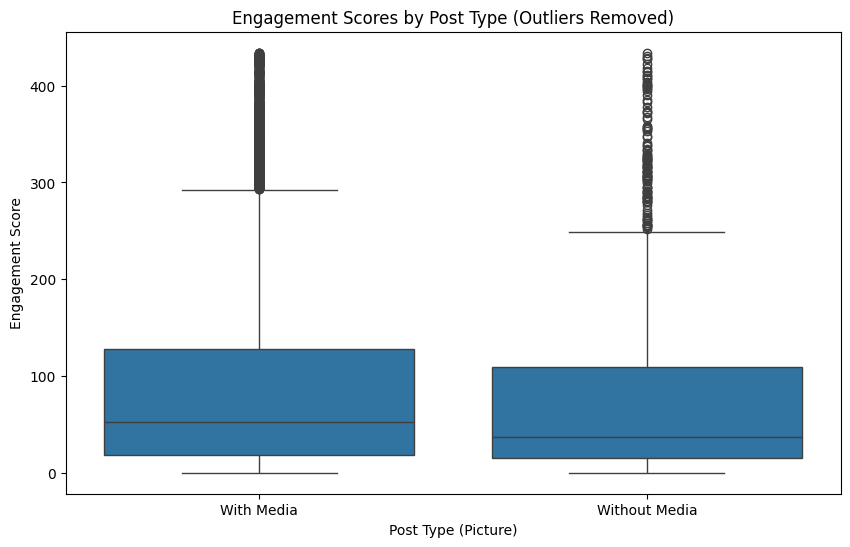

In [303]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered
# create a new column for ease of plotting
df['Group'] = df['post_type'].apply(lambda x: 'With Media' if x == 1 else 'Without Media' if x == 3 else 'Other')

# Remove outliers from the engagement score for 'With Media' and 'Without Media' groups
df_no_outliers = df[df['Group'].isin(['With Media', 'Without Media'])].copy()
df_no_outliers = remove_outliers_iqr(df_no_outliers, 'engagement')

# create a boxplot to visualize the engagement scores without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='engagement', data=df_no_outliers)
plt.title('Engagement Scores by Post Type (Outliers Removed)')
plt.xlabel('Post Type (Picture)')
plt.ylabel('Engagement Score')
plt.show()


### **Testing: Content with Video** vs. **Content without Media**

In [304]:
#separate your data into two groups: one for posts with videos and one for posts without
group_with_media = df[(df['post_type'] == 2) | (df['post_type'] == 2)]['engagement']
group_without_media = df[df['post_type'] == 3]['engagement']

#perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(group_with_media, group_without_media, alternative='greater')

#print the test statistic and p-value
print('Mann-Whitney U Test Statistic:', u_statistic)
print('p-value:', p_value)

#interpret the results
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.")
else:
    print("We fail to reject the null hypothesis. There is not a statistically significant difference in engagement scores between posts with media and without.")


Mann-Whitney U Test Statistic: 1882951.5
p-value: 1.116733619386106e-18
We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.


**Interpretation:** The p-value is `less than 0.05`, which suggests that there is a statistically significant difference in engagement scores between posts with media (videos) and posts without media. This means that, based on this, **posts with media (videos) are associated with higher engagement compared to posts without any media.**

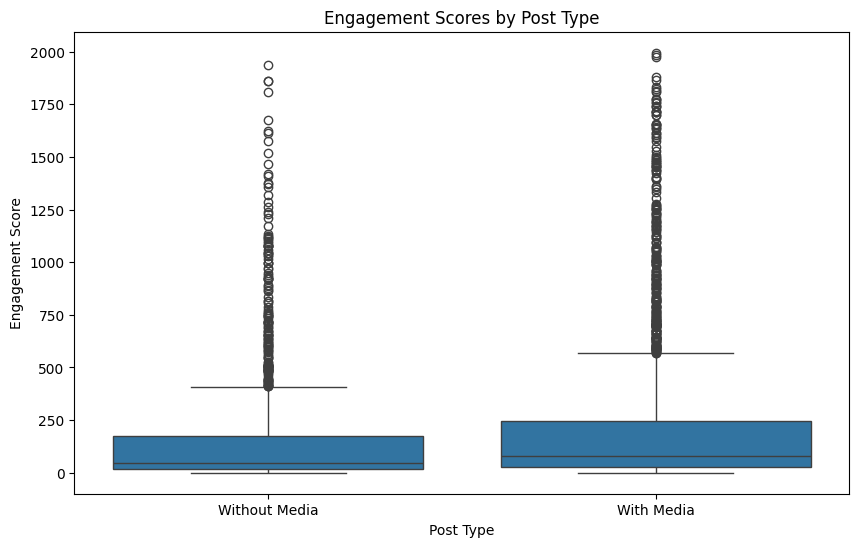

In [305]:

#map the post types to more descriptive labels
df['Post Type Label'] = df['post_type'].map({2: 'With Media', 3: 'Without Media'})

#filter out rows where 'post_type' is not 2 or 3, if there are any
plot_data = df[df['post_type'].isin([2, 3])]

#create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Post Type Label', y='engagement', data=plot_data)
plt.title('Engagement Scores by Post Type')
plt.xlabel('Post Type')
plt.ylabel('Engagement Score')
plt.show()


The box plot displays the engagement scores for two different types of social media posts: those with media (videos) and those without media. **The 'With Media (videos)' category actually has a higher median engagement score compared to the 'Without Media' category**, as well as a wider interquartile range (IQR), indicating a *broader spread of engagement scores.* The *'Without Media' category, while having a lower median engagement score, also shows a narrower IQR, suggesting a more consistent engagement level among those posts.* The presence of numerous outliers in both categories suggests that there are posts that achieve exceptionally high engagement outside the general trend. Given these observations and the Mann-Whitney U test results from a previous analysis, it can be concluded **that posts with media (videos) are generally associated with higher engagement compared to posts without media.**

In order to see the results of the Box-Plots better, **Outliers were removed.**

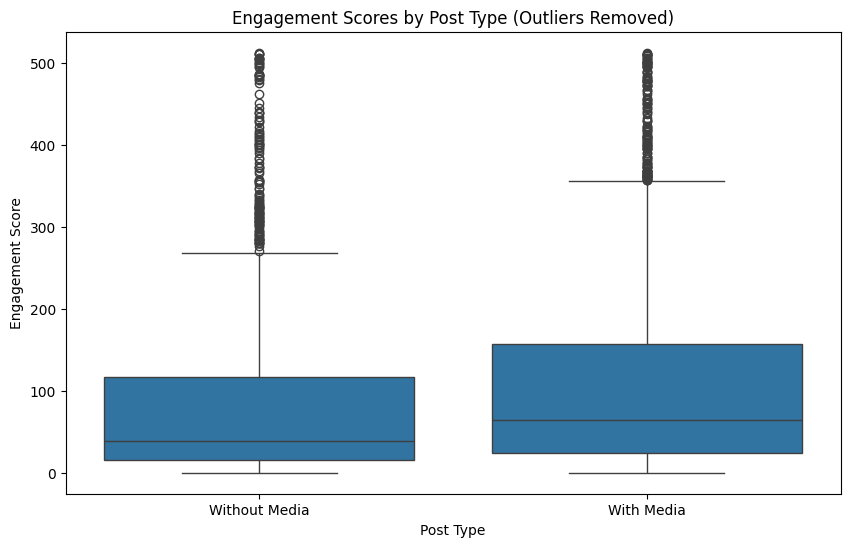

In [306]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered


# create a new column for ease of plotting
df['Group'] = df['post_type'].apply(lambda x: 'With Media' if x == 2 else 'Without Media' if x == 3 else 'Other')

# Remove outliers from the engagement score for 'With Media' and 'Without Media' groups
df_no_outliers = df[df['Group'].isin(['With Media', 'Without Media'])].copy()
df_no_outliers = remove_outliers_iqr(df_no_outliers, 'engagement')

# create a boxplot to visualize the engagement scores without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='engagement', data=df_no_outliers)
plt.title('Engagement Scores by Post Type (Outliers Removed)')
plt.xlabel('Post Type')
plt.ylabel('Engagement Score')
plt.show()


## **Spearman Correlation**

Furthermore, I would like to conduct an Correlation, since this could support the Solving of the Hypothesis. *Since the **Pearson Correlation** is measuring the linear relationship between two continuous variables, it doesnt fit for this dataset.* It assumes that the data is normally distributed. Given that we have already identified that our data is not normally distributed (which led you to choose the Mann-Whitney U test), a *Pearson correlation would not be appropriate in this case.* The **Spearman Correlation** does not assume that data is normally distributed and is used to measure the strength and direction of the monotonic relationship between two variables. *Spearman correlation can be a good choice then since the data is not normally distributed.*

Considering the hypothesis, which are:

* **H2a:** Posts including pictures and videos generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.
* **H2b:** Posts including pictures and videos generate lower engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.

to find out the relationship between the type of post (with media vs. without media) and engagement, the Mann-Whitney U test could be a suitable choice because it compares two independent groups. *In addition, for understanding the **strength and direction** of the relationship between these two variables, the **Spearman correlation** could be considered.*

In [307]:
#calculate Spearman correlation for general media presence vs. engagement
media_presence = df['post_type'].apply(lambda x: 1 if x in [1, 2] else 0)
correlation_media, p_value_media = spearmanr(media_presence, df['engagement'])

#calculate Spearman correlation for pictures vs. engagement
picture_presence = df['post_type'].apply(lambda x: 1 if x == 1 else 0)
correlation_pictures, p_value_pictures = spearmanr(picture_presence, df['engagement'])

#calculate Spearman correlation for videos vs. engagement
video_presence = df['post_type'].apply(lambda x: 1 if x == 2 else 0)
correlation_videos, p_value_videos = spearmanr(video_presence, df['engagement'])

print(f"General Media Presence vs. Engagement:")
print(f"Spearman Correlation Coefficient: {correlation_media:.4f}")
print(f"P-value: {p_value_media:.4f}\n")

print(f"Pictures (1) vs. Engagement:")
print(f"Spearman Correlation Coefficient: {correlation_pictures:.4f}")
print(f"P-value: {p_value_pictures:.4f}\n")

print(f"Videos (2) vs. Engagement:")
print(f"Spearman Correlation Coefficient: {correlation_videos:.4f}")
print(f"P-value: {p_value_videos:.4f}\n")


General Media Presence vs. Engagement:
Spearman Correlation Coefficient: 0.0478
P-value: 0.0000

Pictures (1) vs. Engagement:
Spearman Correlation Coefficient: -0.0224
P-value: 0.0062

Videos (2) vs. Engagement:
Spearman Correlation Coefficient: 0.0647
P-value: 0.0000



The **Spearman correlation analysis** reveals that there is a *slight positive relationship between general media presence and engagement **(coefficient: 0.0478, p-value: 0.0000)**,* indicating that posts with **either type of media tend to be slightly more engaging.** However, when disaggregated, *pictures show a negative correlation with engagement **(coefficient: -0.0224, p-value: 0.0062)**,* suggesting that **posts with pictures might be less engaging than those without media.** In contrast, *videos correlate positively with engagement **(coefficient: 0.0647, p-value: 0.0000)**,* which indicates that posts with videos are more likely to have higher engagement. **These results imply that videos may be more effective than pictures in driving engagement on the platform.**

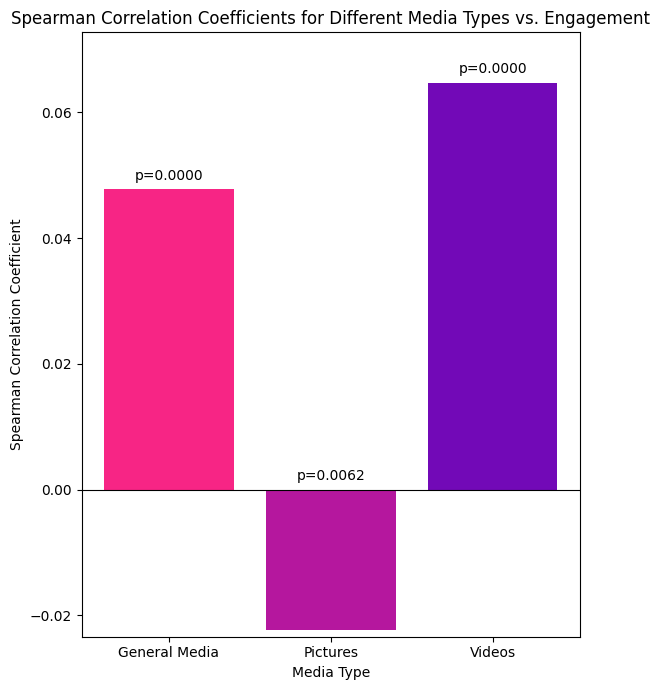

In [308]:
#categories
categories = ['General Media', 'Pictures', 'Videos']
#updated color scheme provided by you
colors = ['#f72585', '#b5179e', '#7209b7']

#create bar chart

#calculate p-values for each correlation
p_values = [p_value_media, p_value_pictures, p_value_videos]

plt.figure(figsize=(6, 7))  #adjusted for a better fit
bars = plt.bar(categories, [correlation_media, correlation_pictures, correlation_videos], color=colors)

#add the p-values on top of the bars, with better alignment
for bar, p_value in zip(bars, p_values):
    yval = bar.get_height()
    # Adjust text position based on the value of y (positive or negative correlation)
    text_position = max(yval, 0) + 0.001  # 0.01 is an offset to position the text above the bar
    plt.text(bar.get_x() + bar.get_width()/2, text_position, f'p={p_value:.4f}', ha='center', va='bottom', color='black')

#set the title and labels
plt.title('Spearman Correlation Coefficients for Different Media Types vs. Engagement')
plt.xlabel('Media Type')
plt.ylabel('Spearman Correlation Coefficient')

# Add a horizontal line at y=0 for better contrast
plt.axhline(0, color='black', linewidth=0.8)

# Customize y-axis limits to make sure there is enough space for the p-value annotations
plt.ylim(min(min(correlation_media, correlation_pictures, correlation_videos) - 0.001, -0.001), max(max(correlation_media, correlation_pictures, correlation_videos) + 0.008, 0.001))

# Show the plot
plt.tight_layout()
plt.show()


* **General Media Presence vs. Engagement:** Shows a **Spearman correlation coefficient** of `0.0478` with a **p-value** of `0.0000`, indicating a *statistically significant but very slight positive association between media presence (both pictures and videos) and engagement.*

* **Pictures vs. Engagement:** Presents a **Spearman correlation coefficient** of `-0.0224` with a **p-value** of `0.0062`, suggesting a *statistically significant slight negative relationship, meaning that as the presence of pictures increases, engagement slightly decreases.*

* **Videos vs. Engagement:** Displays a **Spearman correlation coefficient** `of 0.0647` with a **p-value** of `0.0000`, indicating a *statistically significant positive association between the presence of videos and engagement, which is a stronger positive relationship* than that observed for general media presence.

In [309]:
#head function, to see the new features created through plotting
df.head(5)

,profile,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,nr_likes,post_id,followers,engagement,post_type,Post Type Label,Group
0,wild adventures theme park,16,2,2,2,NaN,13,84679583132_770120045161180,low,17.083333,1,NaN,Other
1,fun spot america,38,1,2,1,NaN,33,184020466977_767286052104076,medium,35.000060,3,Without Media,Without Media
2,fun spot america,23,2,3,2,NaN,21,184020466977_767267948772553,medium,25.000090,2,With Media,With Media
3,disneyland paris,646,52,12,56,NaN,478,652389081615295_775974521237956,high,582.000007,1,NaN,Other
4,silverwood theme park,17,2,0,2,NaN,16,762701550509617_678920137770716,medium,20.000000,2,With Media,With Media


In [310]:
#dropping the specified columns from the df
df = df.drop(columns=['Group', 'Post Type Label'])

Next step is to transform the new created Feature `post_type` into a categorical variable again, since we use this type of feature for the **multi-level analysis**.

In [311]:
#define the mapping from number to string
def number_to_string(number):
    mapping = {1: 'picture', 2: 'video', 3: 'other'}
    return mapping.get(number, 'unknown')

#apply the mapping to the 'post_type' column
df['post_type'] = df['post_type'].apply(number_to_string)

#convert the 'post_type' column to 'object' dtype
df['post_type'] = df['post_type'].astype('object')



In [312]:
#check data types
df.dtypes

profile                   object
nr_reactions               int64
nr_comments                int64
nr_shares                  int64
comments/post              int64
post_interaction_rate    float64
nr_likes                   int64
post_id                   object
followers                 object
engagement               float64
post_type                 object
dtype: object

## **Exporting the dataframe for further analysis**
To work on our multilevel analysis, we will now create a new csv version of the dataframe.

In [313]:
#final check, if df ready for export
df.head(5)

,profile,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,nr_likes,post_id,followers,engagement,post_type
0,wild adventures theme park,16,2,2,2,NaN,13,84679583132_770120045161180,low,17.083333,picture
1,fun spot america,38,1,2,1,NaN,33,184020466977_767286052104076,medium,35.000060,other
2,fun spot america,23,2,3,2,NaN,21,184020466977_767267948772553,medium,25.000090,video
3,disneyland paris,646,52,12,56,NaN,478,652389081615295_775974521237956,high,582.000007,picture
4,silverwood theme park,17,2,0,2,NaN,16,762701550509617_678920137770716,medium,20.000000,video


In [314]:
# Get the directory of the current Jupyter Notebook file
notebook_directory = os.path.dirname(os.path.abspath('__file__'))

# Specify the name of the folder within the repository
folder_name = '02_new dataframes'

# Construct the full path to the folder within the repository
folder_path = os.path.join(notebook_directory, folder_name)

# Define the file path for the CSV file within the folder
csv_file_path = os.path.join(folder_path, 'H2_dataframe.csv')

# Save the updated DataFrame to a CSV file in the specified folder
df.to_csv(csv_file_path, index=False)